## **Simulating Complex Systems with Graph Neural Networks**

Effective simulations of complex systems are essential across various scientific and engineering domains. Yet, these simulations typically come with high computational costs and time requirements. Realistic models often demand significant computational resources, rendering them impractical for many applications. Furthermore, even when resources are available, simulators often fall short in accuracy due to the complexity of underlying system dynamics.

This example implements [Graph Network-based Simulators](https://arxiv.org/pdf/2002.09405.pdf) (GNS), a machine learning framework tailored for simulating complex systems based on data. This framework represents the system's physical states as interconnected graphs of interacting particles, leveraging message-passing among nodes to approximate system dynamics.

### **The SAND Dataset**

We'll utilize the SAND dataset, which comprises simulations of granular systems mimicking sand's intricate frictional characteristics. This dataset is segmented into three subsets: a training set consisting of 1000 simulations, a validation set containing 30 simulations, and a test set comprising 30 simulations. These subsets are stored as npz files. Download the dataset from [here](https://www.transfernow.net/dl/20240416vkui7Rsw).

Use the following code snippet to load the data:

In [2]:
import numpy as np

def load_npz_data(path):
    with np.load(path, allow_pickle=True) as data_file:
        data = [item for _, item in data_file.items()]

    return data

In [3]:
train_data = load_npz_data('dataset/train.npz')
val_data = load_npz_data('dataset/valid.npz')
test_data = load_npz_data('dataset/test.npz')

Accompanying the dataset is a JSON file containing metadata extracted from the simulations. This includes information such as simulation durations and average statistics of velocities and accelerations, which will serve as normalization parameters in subsequent processes.

Use the following code snippet to load the metadata:

In [4]:
import json

def load_json_metadata(path):
    with open(path, 'r') as data_file:
        data = json.load(data_file)
        
    return data

In [5]:
metadata = load_json_metadata('dataset/metadata.json')

print("Metadata:")
print(json.dumps(metadata, indent=4))

Metadata:
{
    "bounds": [
        [
            0.1,
            0.9
        ],
        [
            0.1,
            0.9
        ]
    ],
    "sequence_length": 320,
    "default_connectivity_radius": 0.015,
    "dim": 2,
    "dt": 0.0025,
    "vel_mean": [
        5.123277536458455e-06,
        -0.0009965205918140803
    ],
    "vel_std": [
        0.0021978993231675805,
        0.0026653552458701774
    ],
    "acc_mean": [
        5.237611158734309e-07,
        2.3633027988858656e-07
    ],
    "acc_std": [
        0.0002582944917306106,
        0.00029554531667679154
    ]
}


With the data loaded, we proceed to visualize one of the simulations within the training data.

In [6]:
import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import HTML


random_sample = np.random.randint(0, len(train_data))
positions = train_data[random_sample][0] # (1)

fig, ax = plt.subplots(figsize=(6, 6)) 
scatter = ax.scatter([], [], s=50, c="yellow", edgecolors="black", linewidth=0.5) # (2)
ax.set_xlim(0, 1) # (3)
ax.set_xticks([]) # (4)
ax.set_ylim(0, 1) # (5)
ax.set_yticks([]) # (6)

def update(frame): # (7)
    scatter.set_offsets(positions[frame]) # (8)
    return scatter, # (9)

ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=10, blit=True) # (10)

# Display the animation
html_video = HTML(ani.to_html5_video()) # (11)

plt.close()
html_video # (12)

This code animates the simulation using matplotlib:

**(1)**  It randomly selects an index within the range of train_data and retrieves the corresponding position data.

**(2)**  A scatter plot canvas with no data points initially plotted is created.

**(3-6)** The code sets the x-axis and y-axis limits to be within the range of 0 to 1 and removes the ticks for both axes.

**(7)** The `update` function is defined, which will be called for each frame of the animation. It takes a `frame` parameter representing the frame number.

**(8)** Within the `update` function, the position of the scatter plot is updated based on the data for the current frame.

**(9)** The function returns the scatter plot object.

**(10)** The animation is created using the `FuncAnimation` class, specifying the figure, the update function, the number of frames, and the interval between frames. `blit=True` improves rendering performance.

**(11)** The animation is converted to an HTML5 video format using the `to_html5_video()` method.

**(12)** Finally, the HTML video of the animation is displayed.

### **Building the Graph Network-based Simulator**

**Figure 1** depicts the Graph Network-based Simulator (GNS). This simulator utilizes a graph neural network to process the system's physical states, which are represented as a graph.

<div style="text-align:center">
    <figure>
        <img src="images/GNS.png" alt="Image Description" width="800" height=auto />
        <figcaption><strong>Figure 1.</strong></figcaption>
    </figure>
</div>

The graph comprises nodes, representing particles, and edges, describing interactions between spatially close particles as set by a distance threshold (**Figure 1**, left). Nodes include a sequence of the particle's $N$ previous velocities and their relative distances to the simulation boundaries. Edges feature the relative positional displacement between connected particles and its magnitude.

The GNS updates the graph representation through message-passing. 

Let us define a message-passing model for the GNS:

In [7]:
import torch.nn as nn

from deeplay import GraphToNodeMPM

model = GraphToNodeMPM(
    hidden_features=[ # (1)
        64,
    ]
    * 9,
    out_features=2, # (2)
)

The implemented model involves an encoder, a message-passing backbone processor, and a decoder. 

Initially, the encoder, consisting of two dense neural networks, processes the node and edge features to derive high-level representations. 

Next, the message-passing backbone iteratively updates these features, **(1)** employing nine message-passing layers, each with a latent dimension of 64. 

Finally, the decoder utilizes the updated node features to predict the system's dynamic features, **(2)** such as per-particle 2D accelerations.

Additionally, the GNS implements a variant of the standard message-passing approach, incorporating skip connections between the input and updated features. This modification, detailed in **Figure 1** (middle), helps the model retain input feature information, facilitating deeper and more stable information propagation:

In [8]:
from deeplay import ResidualMessagePassingNeuralNetwork

rmp_backbone = ResidualMessagePassingNeuralNetwork(
    hidden_features=model.backbone.hidden_features, # (1)
    out_features=model.backbone.out_features, # (2)
    out_activation=nn.ReLU, # (3)
)
model.replace("backbone", rmp_backbone) # (4)
model = model.create()

This code snippet creates a Residual Message Passing backbone (`rmp_backbone`) by configuring it with parameters inherited from `model`.

The code:

**(1-2)** Sets the hidden and output features of the new backbone neural network to be the same as those of the `model`.

**(3)** Specifies the ReLU activation function for the output layer to match the `model` activations.

**(4)** Replaces the existing backbone of `model` with `rmp_backbone`.

Finally, the model summary is printed.

In [9]:
print(model)

GraphToNodeMPM(
  (encoder): Parallel(
    (0-1): 2 x MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LayerActivationNormalizationDropout(
          (layer): LazyLinear(in_features=0, out_features=64, bias=True)
          (activation): Identity()
          (normalization): Identity()
          (dropout): Identity()
        )
      )
    )
  )
  (backbone): ResidualMessagePassingNeuralNetwork(
    (blocks): LayerList(
      (0-8): 9 x LayerSkip(
        (layer): TransformPropagateUpdate(
          (transform): Transform(
            (combine): Cat()
            (layer): LazyLinear(in_features=0, out_features=64, bias=True)
            (activation): ReLU()
          )
          (propagate): Sum()
          (update): Update(
            (combine): Cat()
            (layer): LazyLinear(in_features=0, out_features=64, bias=True)
            (activation): ReLU()
          )
        )
        (skip): AddDict()
      )
    )
  )
  (selector): FromDict(x)
  (pool): Identity()
  (h

During training, the Graph Network-based Simulator (GNS) predicts the future accelerations of all particles within the system (**Figure 2**, top and middle).

However, the primary objective is to predict the future positions of these particles to effectively simulate the system's dynamics. Thus, in simulation mode, the GNS predicts accelerations, utilizing these predictions to update the velocities and positions of the particles through an Euler integration scheme. The resulting positions are used as input for the next prediction step, thereby simulating the system's evolution (**Figure 2**, bottom).

<div style="text-align:center">
    <figure>
        <img src="images/training-sim-modes.png" alt="Image Description" width="500" height=auto />
        <figcaption><strong>Figure 2.</strong></figcaption>
    </figure>
</div>

### **Building the Dataset**

We proceed to create a dataset class that fits the inputs and outputs required by the model during training.

In [10]:
import torch
from torch.utils.data import Dataset

from torch_geometric.data import Data


class ParticleDataset(Dataset):
    def __init__(self, data, metadata, window_size, noise_std):
        super().__init__()

        self.data = data  # (1)
        self.metadata = metadata  # (2)

        self.window_size = window_size  # (3)
        self.noise_std = noise_std  # (4)

        self.lengths = [len(positions) - window_size for positions, *_ in data]

        self.num_windows = sum(self.lengths)  
        self.length_cumsum = np.cumsum(self.lengths)

    def __len__(self):
        return self.num_windows

    def __getitem__(self, idx):
        windowed_positions, label_positions = self.get_windowed_positions(idx)  # (5)

        noise = self.random_walk_noise(windowed_positions, noise_std=self.noise_std) # (6)
        noisy_windowed_positions = windowed_positions + noise # (7)

        x, edge_index, edge_attr = self.compute_graph(noisy_windowed_positions) # (8)

        corrected_label_positions = label_positions + noise[:, -1] # (9)
        current_positions, previous_positions = ( # (10)
            noisy_windowed_positions[:, -1],
            noisy_windowed_positions[:, -2],
        )
        current_velocities = current_positions - previous_positions # (11)
        next_velocities = corrected_label_positions - current_positions # (12)
        label_accelerations = next_velocities - current_velocities # (13)

        norm_label_accelerations = label_accelerations - self.metadata["acc_mean"] # (14)
        norm_label_accelerations /= (
            np.square(self.metadata["acc_std"]) + self.noise_std**2 # (15)
        ) ** 0.5

        return Data( # (16)
            x=torch.tensor(x, dtype=torch.float32),
            edge_index=torch.tensor(edge_index, dtype=torch.long),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float32),
            y=torch.tensor(norm_label_accelerations, dtype=torch.float32),
        )

    def get_windowed_positions(self, idx):
        sample_idx = np.searchsorted(self.length_cumsum - 1, idx, side="left")

        if sample_idx == 0:
            start_of_selected_sample = 0
        else:
            start_of_selected_sample = self.length_cumsum[sample_idx - 1]

        start_of_window = idx - start_of_selected_sample
        end_of_window = start_of_window + self.window_size

        positions = self.data[sample_idx][0].copy()
        windowed_positions = positions[start_of_window:end_of_window]
        windowed_positions = np.transpose(windowed_positions, (1, 0, 2))

        label_positions = positions[end_of_window]

        return windowed_positions, label_positions

    def random_walk_noise(self, windowed_positions, noise_std):
        velocities = np.diff(windowed_positions, axis=1) # (6.1)

        num_velocities = velocities.shape[1]
        velocity_sequence_noise = np.random.randn(*list(velocities.shape)) * (
            noise_std / num_velocities**0.5
        ) # (6.2)
        velocity_sequence_noise = np.cumsum(velocity_sequence_noise, axis=1) # (6.3)

        noise = np.concatenate( # (6.4)
            [
                np.zeros_like(velocity_sequence_noise[:, 0:1]),
                np.cumsum(velocity_sequence_noise, axis=1),
            ],
            axis=1,
        )

        return noise

    def compute_graph(self, windowed_positions):
        current_positions = windowed_positions[:, -1] # (8.1)

        edge_index, edge_attr = self.compute_connectivity(
            current_positions, radius=self.metadata["default_connectivity_radius"] # (8.2)
        )

        x = self.compute_node_features(current_positions, windowed_positions) # (8.3)

        return x, edge_index, edge_attr

    def compute_connectivity(self, windowed_positions, radius):
        displacements = windowed_positions[:, None, :] - windowed_positions[None, :, :]

        distances = np.linalg.norm(displacements, axis=-1)
        mask = distances < radius
        np.fill_diagonal(mask, False)

        edge_index = np.argwhere(mask)
        edge_attr = (
            np.concatenate([displacements[mask], distances[mask][:, None]], axis=-1)
            / radius
        )

        return edge_index.T, edge_attr

    def compute_node_features(self, current_positions, windowed_positions):
        velocities = np.diff(windowed_positions, axis=1)

        norm_velocities = velocities - self.metadata["vel_mean"]
        norm_velocities /= (
            np.square(self.metadata["vel_std"]) + self.noise_std**2
        ) ** 0.5
        norm_velocities = norm_velocities.reshape(current_positions.shape[0], -1)

        boundaries = np.array(self.metadata["bounds"])
        distance_to_lower_bound = current_positions - boundaries[:, 0][None]
        distance_to_upper_bound = boundaries[:, 1][None] - current_positions
        distance_to_bounds = np.concatenate(
            [distance_to_lower_bound, distance_to_upper_bound], axis=-1
        )
        norm_distance_to_bounds = (
            distance_to_bounds / self.metadata["default_connectivity_radius"]
        )
        norm_distance_to_bounds = np.clip(norm_distance_to_bounds, -1, 1)

        return np.concatenate([norm_velocities, norm_distance_to_bounds], axis=-1)

The code above defines the `ParticleDataset` class inheriting from PyTorch's `Dataset`.

The class constructor initializes the dataset with the provided **(1)** data and **(2)** metadata. Additionally, it configures parameters such as **(3)** the window size for cropping trajectory sections and **(4)** the standard deviation of noise for data augmentation.

The `__getitem__` method is responsible for loading individual data samples. **(5)** Here, a random simulation is selected from the dataset, and a trajectory section of the specified window size is cropped using the `get_windowed_positions method`. This cropping ensures that each sample represents a sequential segment of the trajectory, which is crucial for learning temporal patterns. Additionally, `get_windowed_positions` provides the subsequent particle positions required for computing ground-truth accelerations.

To mitigate the accumulation of errors during the prediction process, especially when iteratively forecasting future particle positions, a strategy is employed to make the model robust to noisy inputs. **(6-7)** During training, the input velocities of the model are corrupted with random-walk noise, aligning the training distribution closer to that generated during simulation rollouts. **(6.1-6.4)** This approach involves adjusting input positions to incorporate noise while ensuring the scale in velocity at the last step remains fixed (see **Appendix A**).

From the noisy, cropped trajectory, **(8)** the code proceeds to construct the input graph using the `compute_graph` method. **(8.1-8.2)** This method computes connectivity information to establish relationships between particles based on their proximity. Subsequently, **(8.3)** it extracts node features representing particle velocities across current and previous time steps, along with their distances from simulation boundaries.

After feature extraction, we proceed to label preparation, where future accelerations of particles are computed. **(9-13)** This involves calculating the difference between future and current velocities. Before this calculation, velocities are adjusted by adding the last step's noise to the label positions, ensuring the model predicts future accelerations accurately, despite noisy input positions (see **Appendix B**). Additionally, for training stability, **(14-15)** the target accelerations are normalized using average acceleration statistics from the metadata and considering the noise standard deviation.

**(16)** Finally, `ParticleDataset` returns a dictionary containing the node features (`x`), edge information (`edge_index` and `edge_attr`), and the target accelerations (`y`).

The following code snippet initializes `train_dataset`, v`al_dataset`, and `test_dataset`, for training, validation, and testing purposes, respectively. Each dataset is constructed using the `ParticleDataset` class.

In [11]:
noise_std = 3e-4 # (1)
window_size = 6 # (2)

train_dataset = ParticleDataset(
    train_data, metadata, window_size=window_size, noise_std=noise_std
)
val_dataset = ParticleDataset(
    val_data, metadata, window_size=window_size, noise_std=noise_std
)
test_dataset = ParticleDataset(
    test_data, metadata, window_size=window_size, noise_std=noise_std
)

Here, **(1)** the noisy standard deviation `noise_std` is set to 3e-4, and **(2)** the window size is set to 6 (including the current timestep and the preceding 5 timesteps). The datasets are initialized with the training, validation, and test data, along with the metadata.

### **Defining the Data Loaders**

Now, we proceed to define the data loaders, which are responsible for feeding the data to the model during training and evaluation.

In [12]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, pin_memory=True)

# NOTE: num_workers = 4 speeds up data loading (A100), yet it differs between platforms

c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### **Training the Model**

Use the following code snippet to train the model:

In [13]:
from deeplay import Regressor, Trainer, Adam

import torch.nn as nn
from lightning.pytorch.callbacks import ModelCheckpoint

regressor = Regressor(
    model,
    loss=nn.MSELoss(),
    optimizer=Adam(lr=1e-4),
)
regressor = regressor.create()

checkpoint_callback = ModelCheckpoint(  # (2)
    monitor="val_loss",
    dirpath="models",
    filename="SAND-GNS-model{epoch:02d}-val_loss{val_loss:.2f}",
    auto_insert_metric_name=False,
)

trainer = Trainer(max_epochs=5, callbacks=[checkpoint_callback])

#trainer.fit(regressor, train_loader, val_loader)

c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: otobuf is an invalid version and will not be supported in a future release
  warnings.warn(
c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: 3df76a9e45e3a1d6165e42c565a2f8622f7c1f8c- is an invalid version and will not be supported in a future release
  warnings.warn(


The duration of the training process can vary based on the hardware and the number of epochs specified. By default, the model is trained for five epochs, which already produces good results. However, if you want better performance, you can increase the number of epochs, but this will result in longer training times.

Alternatively, you can bypass the training process entirely and download the pre-trained model, which has been trained for 30 epochs, by clicking [here](https://we.tl/t-o3gAV1dMSN).

In [18]:
import os

best_model_path = os.path.join("models", "SAND-GNS-model.ckpt")
regressor.load_state_dict(torch.load(best_model_path)["state_dict"])

<All keys matched successfully>

After loading the pre-trained model, we can evaluate its performance on the test set.

In [19]:
trainer.test(regressor, test_loader)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.05352632701396942    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.05352632701396942}]

You should expect an MAE of around 0.05 for the test set, exhibiting the model's ability to accurately predict particle accelerations despite the presence of noise.

### **Simulating the System**

Finally, we simulate the system using the trained model. The simulation process involves iteratively predicting future accelerations and updating particle positions based on these predictions.

We define a function, `simulate`, to perform a rollout simulation using the trained model:

In [35]:
def simulate(model, positions, metadata, window_size, noise_std):
    model.eval()

    total_time = positions.shape[0] 
    windowed_positions = positions[:window_size].copy() # (1)
    windowed_positions = np.transpose(windowed_positions, (1, 0, 2))

    for _ in range(total_time - window_size):
        with torch.no_grad():
            x, edge_index, edge_attr = val_dataset.compute_graph(  # (2)
                windowed_positions[:, -window_size:]
            )

            graph = Data( # (3)
                x=torch.tensor(x, dtype=torch.float32),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr, dtype=torch.float32),
            )

            graph = graph.to(model.device)
            acceleration = model(graph) # (4)
            acceleration = ( # (5)
                acceleration * (torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2) ** 0.5
                + torch.tensor(metadata["acc_mean"])
            )
            acceleration = acceleration.cpu().numpy()

            # (6)
            current_position = windowed_positions[:, -1]
            current_velocity = current_position - windowed_positions[:, -2]
            next_velocity = current_velocity + acceleration
            next_position = current_position + next_velocity

            windowed_positions = np.concatenate( # (7)
                [windowed_positions, next_position[:, None]], axis=1
            )

    return windowed_positions

In this function, **(1)** the initial positions are cropped to create a window of positions, encompassing the specified `window_size`. This window serves as the initial input for simulation.

A loop iterates through the time steps. Within each iteration, **(2)** the `compute_graph` method of `val_dataset` is called to generate the graph representation based on the current windowed positions. **(3)** Next, a `Data` object is then created to encapsulate the graph, containing node features (`x`), edge indices (`edge_index`), and edge attributes (`edge_attr`). 

**(4)** The model predicts accelerations from the provided graph representation.  **(6)** The predicted accelerations are scaled to match the data distribution. 

**(7)** Next, based on the predicted accelerations, the function calculates the next position of the particles using an Euler integration scheme. 

**(8)** The newly computed next position is concatenated with the existing windowed positions to update the simulation window for the next iteration.

Finally, we visualize the simulation using the following code snippet:

In [44]:
def animate_simulation(sample_idx, regressor, test_data, metadata, window_size, noise_std):
    positions = test_data[sample_idx][0]
    simulated_positions = simulate(regressor, positions, metadata, window_size, noise_std)
    simulated_positions = np.transpose(simulated_positions , (1, 0, 2))
    gt = test_data[idx][0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    scatters = [ax[0].scatter([], [], s=50, c="yellow", edgecolors="black", linewidth=0.5),
                ax[1].scatter([], [], s=50, c="yellow", edgecolors="black", linewidth=0.5)]
    ax[0].set_xlim(0, 1)
    ax[0].set_xticks([])
    ax[0].set_ylim(0, 1)
    ax[0].set_yticks([])
    ax[1].set_xlim(0, 1)
    ax[1].set_xticks([])
    ax[1].set_ylim(0, 1)
    ax[1].set_yticks([])
    ax[0].set_title("Ground Truth")
    ax[1].set_title("Simulated")

    def update(frame):
        scatters[0].set_offsets(positions[frame])
        scatters[1].set_offsets(simulated_positions[frame])
        return scatters

    ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=10, blit=True)

    # Display the animation
    html_video = HTML(ani.to_html5_video())

    plt.close() 
    return html_video

In [45]:
animate_simulation(23, regressor, test_data, metadata, window_size, noise_std)

In [46]:
animate_simulation(18, regressor, test_data, metadata, window_size, noise_std)

In [51]:
animate_simulation(29, regressor, test_data, metadata, window_size, noise_std)

### **Appendix**

**Appendix A**

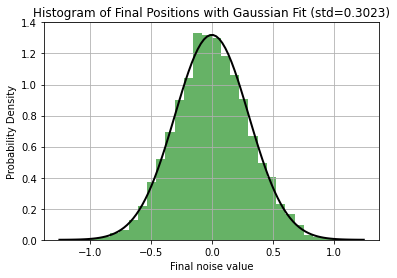

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Number of trajectories
num_trajectories = 10000

# Number of time steps
num_steps = 100

# Generate random numbers for each trajectory and plot
final_positions = []

for i in range(num_trajectories):
    # Generate an array of random numbers from a standard normal distribution
    x = np.random.randn(num_steps)
    
    # Scale the random numbers by multiplying with (std/ num_steps**0.5)
    x1 = x * (0.3 / num_steps**0.5)
    
    # Calculate the cumulative sum of the scaled random numbers
    y = np.cumsum(x1)
    
    # Append the noise value at the last time step
    final_positions.append(y[-1])

# Plot histogram of final positions
plt.hist(final_positions, bins=30, density=True, alpha=0.6, color='g')

# Fit a Gaussian curve to the histogram
mu, std = norm.fit(final_positions)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Final noise value')
plt.ylabel('Probability Density')
plt.title(f'Histogram of Final Positions with Gaussian Fit (std={std:.4f})')
plt.grid(True)

plt.show()


**Appendix B**

Displacement from the last position to the label position:
[0.00275448 0.11155924]
Displacement from the last noisy position to the corrected position:
[0.00275448 0.11155924]


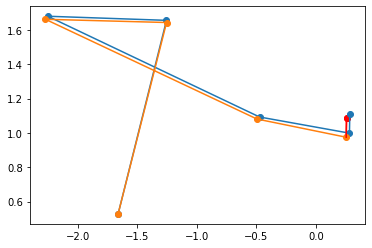

In [48]:
# define a random 2D trajectory
num_steps = 6
trajectory = np.random.randn(num_steps, 2).cumsum(axis=0)


# extract the first 5 steps as the input sequence
windowed_positions = trajectory[:5]

# compute velocities
velocities = np.diff(windowed_positions, axis=0)

# compute the noise
velocity_noise = np.random.randn(*velocities.shape) * (0.03 / num_steps**0.5)
velocity_noise = np.cumsum(velocity_noise, axis=0)


noise = np.concatenate(
            [
                np.zeros_like(velocity_noise[0:1, :]),
                np.cumsum(velocity_noise, axis=0),
            ],
            axis=0,
        )
noisy_positions = windowed_positions + noise

# Correct the last position
corrected_position = trajectory[5] + noise[-1]

plt.scatter(corrected_position[0], corrected_position[1], c='r')
# Connect the corrected position to the last noisy position
plt.plot([noisy_positions[-1, 0], corrected_position[0]], [noisy_positions[-1, 1], corrected_position[1]], 'r-')

# plot the trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], 'o-')

# plot the noisy 5 first positions
plt.plot(noisy_positions[:, 0], noisy_positions[:, 1], 'o-')

# plot correct position
plt.scatter(corrected_position[0], corrected_position[1], c='r')
# Connect the corrected position to the last noisy position
plt.plot([noisy_positions[-1, 0], corrected_position[0]], [noisy_positions[-1, 1], corrected_position[1]], 'r-')


print("Displacement from the last position to the label position:")
print(trajectory[5] - trajectory[4])

print("Displacement from the last noisy position to the corrected position:")
print(corrected_position - noisy_positions[-1])
